In [1]:
'''
Env: python 3.9
Reads from: /scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/
calculates <A> & <u>

Sanity Check: replicate NH18 Fig.2
'''

# Notice: column_u is not desired! use column_zonal_wind_u!

'\nEnv: python 3.9\nReads from: /scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/\ncalculates <A> & <u>\n\nSanity Check: replicate NH18 Fig.2\n'

(121, 240)


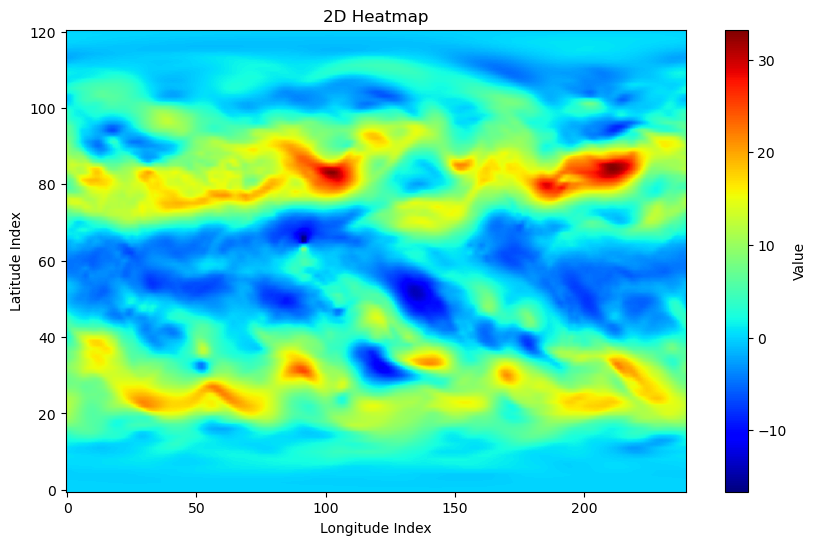

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/column_zonal_wind_u_1991_1991_03_10_06.npy')

# Print the shape of the data
print(data.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(data, aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label='Value')
plt.title('2D Heatmap')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()



(121, 240)


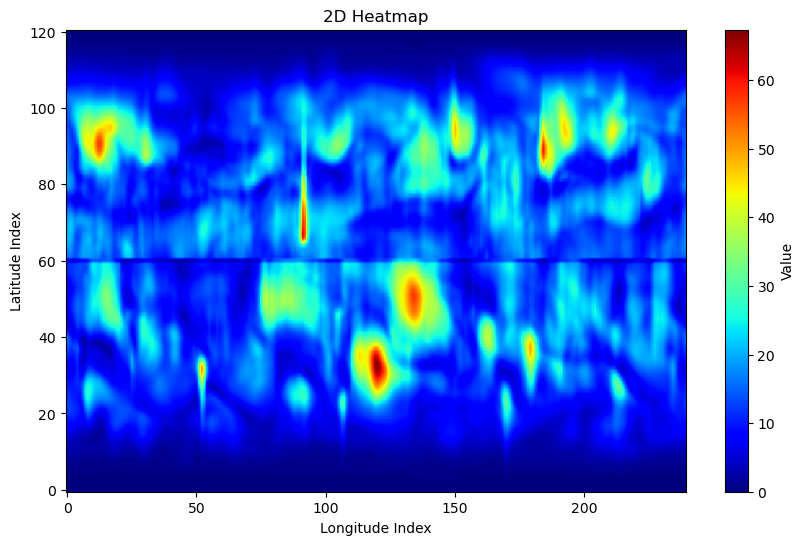

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/column_LWA_1991_1991_03_10_06.npy')

# Print the shape of the data
print(data2.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(data2, aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label='Value')
plt.title('2D Heatmap')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()



In [8]:
import os
import numpy as np
import re
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

all_files = os.listdir(folder)
lwa_files = sorted([f for f in all_files if 'column_LWA' in f])
u_files = sorted([f for f in all_files if 'column_zonal_wind_u' in f])

def is_winter(filename):
    match = re.search(r'_(\d{4})_(\d{2})_', filename)
    if match:
        month = int(match.group(2))
        return month in [12, 1, 2]
    return False

lwa_files_winter = [f for f in lwa_files if is_winter(f)]
u_files_winter = [f for f in u_files if is_winter(f)]

def extract_date(filename):
    match = re.search(r'_(\d{4}_\d{2}_\d{2}_\d{2})', filename)
    if match:
        return match.group(1)
    return None

lwa_data = {extract_date(f): np.load(os.path.join(folder, f)) for f in tqdm(lwa_files_winter, desc="Loading LWA files")}
u_data = {extract_date(f): np.load(os.path.join(folder, f)) for f in u_files_winter}  # We don't add tqdm here because u_data loading is instantaneous with the keys already known from lwa_data

def process_data_point(args):
    i, j = args
    pairs = []
    for date in lwa_data:
        if date in u_data:
            lwa_val = lwa_data[date][i, j]
            u_val = u_data[date][i, j]
            pairs.append((lwa_val, u_val, date))
    return (i, j, pairs)

# Parallelize the process
args = [(i, j) for i in range(121) for j in range(240)]

with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_data_point, args), total=len(args), desc="Processing data points"))

combined_array = np.empty((121, 240), dtype=object)

for i, j, pairs in results:
    combined_array[i, j] = pairs

np.save(os.path.join(save_folder, 'combined_data_raw.npy'), combined_array)


Processing data points: 100%|██████████| 29040/29040 [07:17<00:00, 66.30it/s] 


In [1]:
import numpy as np
import os

save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"
# Path to the saved npy file
file_path = os.path.join(save_folder, 'combined_data_raw.npy')

# Load the data from the npy file
loaded_data = np.load(file_path, allow_pickle=True)

# Print the data format (type) and dimensions
print("Data Type:", type(loaded_data))
print("Shape:", loaded_data.shape)

# Optionally, if you want to see a sample from the data:
print("\nSample Data (from [91,234] index):", loaded_data[91, 234])


Data Type: <class 'numpy.ndarray'>
Shape: (121, 240)

Sample Data (from [91,234] index): [(18.59140101580684, 20.07721836451291, '1979_01_01_00'), (24.917189286693016, 18.772435997615478, '1979_01_01_06'), (31.065373656271746, 16.030491316249158, '1979_01_01_12'), (26.647360084118606, 14.126542244000284, '1979_01_01_18'), (21.155937005602166, 13.322513994172121, '1979_01_02_00'), (19.818458068041803, 14.394546615683447, '1979_01_02_06'), (16.21803288099067, 14.818133246980409, '1979_01_02_12'), (25.857259442822514, 15.943306692204128, '1979_01_02_18'), (31.943555351548884, 13.56206939085071, '1979_01_03_00'), (25.420649003757216, 13.290930925174072, '1979_01_03_06'), (18.657953910274994, 13.570082016127321, '1979_01_03_12'), (14.859936738566825, 12.105780212251108, '1979_01_03_18'), (11.663066340951124, 9.727633947238845, '1979_01_04_00'), (12.478224014962203, 8.355830011635017, '1979_01_04_06'), (16.70013204526684, 6.057695727658278, '1979_01_04_12'), (22.46653233148424, 3.99990161830

In [2]:
import numpy as np
import os
from scipy.stats import linregress
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# # Load the data
# save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"
# file_path = os.path.join(save_folder, 'combined_data_raw.npy')
# loaded_data = np.load(file_path, allow_pickle=True)

# Define the function for linear regression
def compute_slope(args):
    i, j = args
    data_list = loaded_data[i, j]
    lwa_vals = [item[0] for item in data_list]
    u_vals = [item[1] for item in data_list]
    
    try:
        slope, _, _, _, _ = linregress(u_vals, lwa_vals)
        return -slope  # Return negative slope
    except:
        print("error occurred at: ", i, j)
        return 0.0  # Return 0 if any errors occur

# Prepare arguments for parallel processing
args = [(i, j) for i in range(121) for j in range(240)]

# Use multiprocessing to compute slope values
with Pool(cpu_count()-8) as pool:
    slope_results = list(tqdm(pool.imap(compute_slope, args), total=len(args), desc="Computing slopes"))

# Convert results to a 2D numpy array
slope_array = np.array(slope_results).reshape(121, 240)

# Save the results to a npy file
np.save(os.path.join(save_folder, 'slope_data.npy'), slope_array)


Computing slopes: 100%|██████████| 29040/29040 [00:05<00:00, 4931.53it/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF/slope_data.npy')

# Print the shape of the data
print(data2.shape)
print(data2[:20, :20])




(121, 240)
[[-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.00116345 -0.0011529  -0.00130293 -0.00116674 -0.001219   -0.00129178
  -0.00156008 -0.00143167 -0.00116662 -0.00133409 -0.00129133 -0.00123527
  -0.00137207 -0.00139385 -0.00153711 -0.00144524 -0.00133956 -0.00153364
  -0.00163707 -0.0017077 ]
 [ 0.01354142  0.01363155  0.01326187  0.01298328  0.01299697  0.01318809
   0.01283789  0.01294682  0.01313411  0.01236645  0.01230798  0.01266219
   0.01199634  0.01126064  0.01051456  0.0105461   0.01027078  0.00909065
   0.00876148  0.00832871]
 [ 0.03831848  0.03843908  0.03753654  0.03787907  0.03784495  0.03840235
   0.03861878  0.03864265  0.03850928  0.03747911  0.03753121  0.03760578
   0.03650759  0.03449951  0.03279882  0.03160324  0.03005581  0.02766653
   0.0262851   0.02488735]
 [ 0.06512067  0.

In [1]:
# cov 
import numpy as np
import os

save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"
# Path to the saved npy file
file_path = os.path.join(save_folder, 'combined_data_raw.npy')

# Load the data from the npy file
loaded_data = np.load(file_path, allow_pickle=True)

# Print the data format (type) and dimensions
print("Data Type:", type(loaded_data))
print("Shape:", loaded_data.shape)



Data Type: <class 'numpy.ndarray'>
Shape: (121, 240)


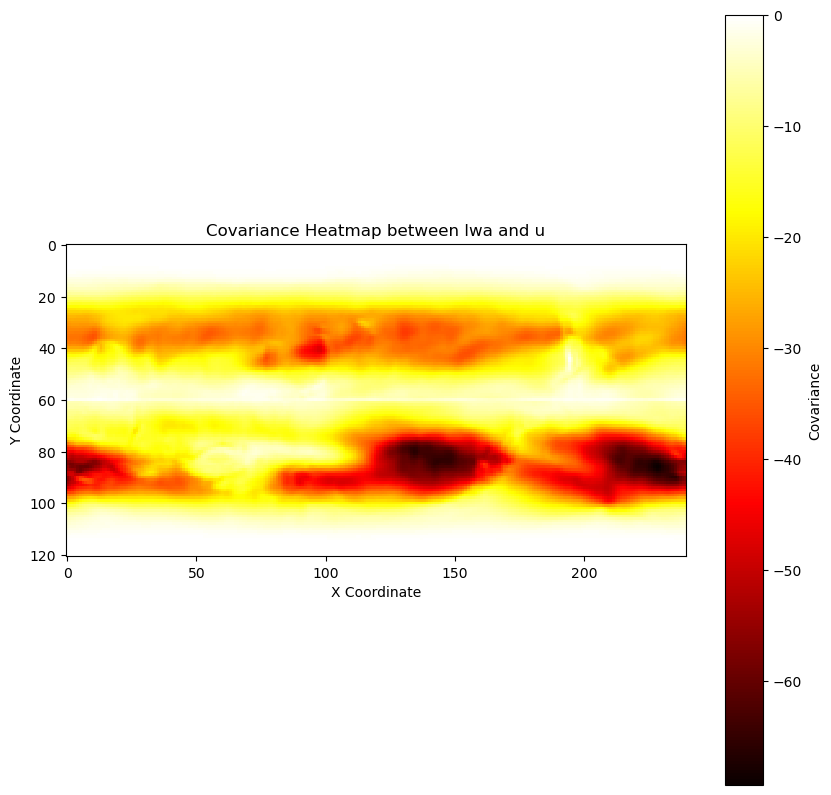

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os

# Define the function to calculate covariance for a specific point
def calculate_covariance(point_data):
    lwa_values = [entry[0] for entry in point_data]
    u_values = [entry[1] for entry in point_data]
    covariance = np.cov(lwa_values, u_values)[0, 1]  # Extracting covariance value
    return covariance

# Use joblib's Parallel and delayed to parallelize the computation
cov_matrix = np.zeros((loaded_data.shape[0], loaded_data.shape[1]))

# Using all available CPU cores
results = Parallel(n_jobs=-1)(delayed(calculate_covariance)(loaded_data[i, j]) for i in range(loaded_data.shape[0]) for j in range(loaded_data.shape[1]))

# Convert the results into the desired matrix format
for idx, value in enumerate(results):
    i, j = divmod(idx, loaded_data.shape[1])
    cov_matrix[i, j] = value



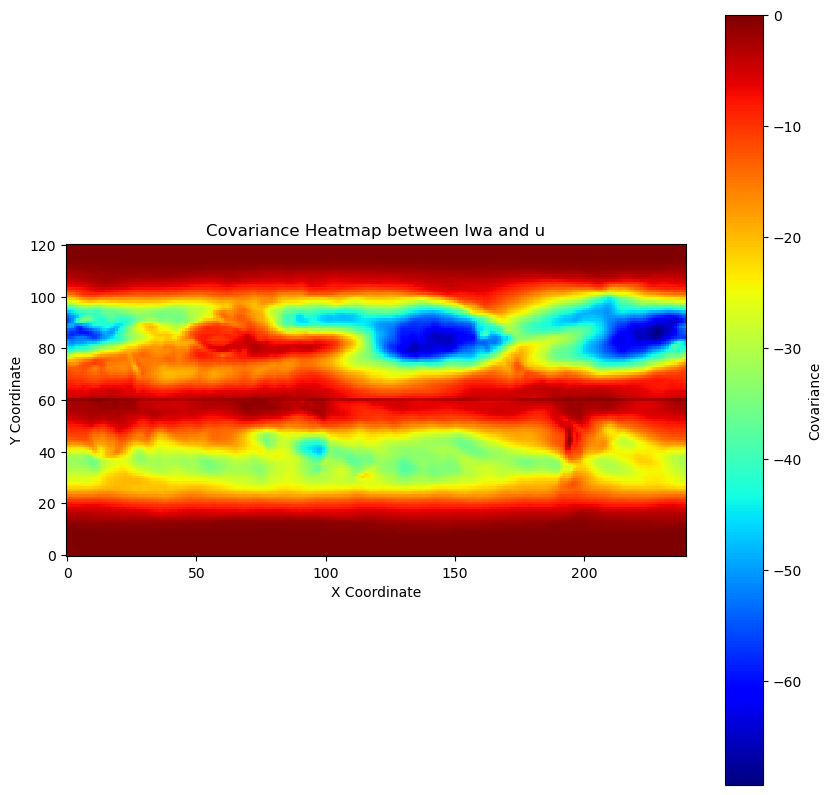

In [3]:


# Save the cov_matrix as a 2D npy file
save_path = os.path.join("/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF/", "cov_matrix_all_year.npy")  
np.save(save_path, cov_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 10))
plt.imshow(cov_matrix, cmap='jet', origin='lower', interpolation='nearest')  # Set cmap to 'jet' and origin to 'lower'
plt.colorbar(label='Covariance')
plt.title('Covariance Heatmap between lwa and u')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


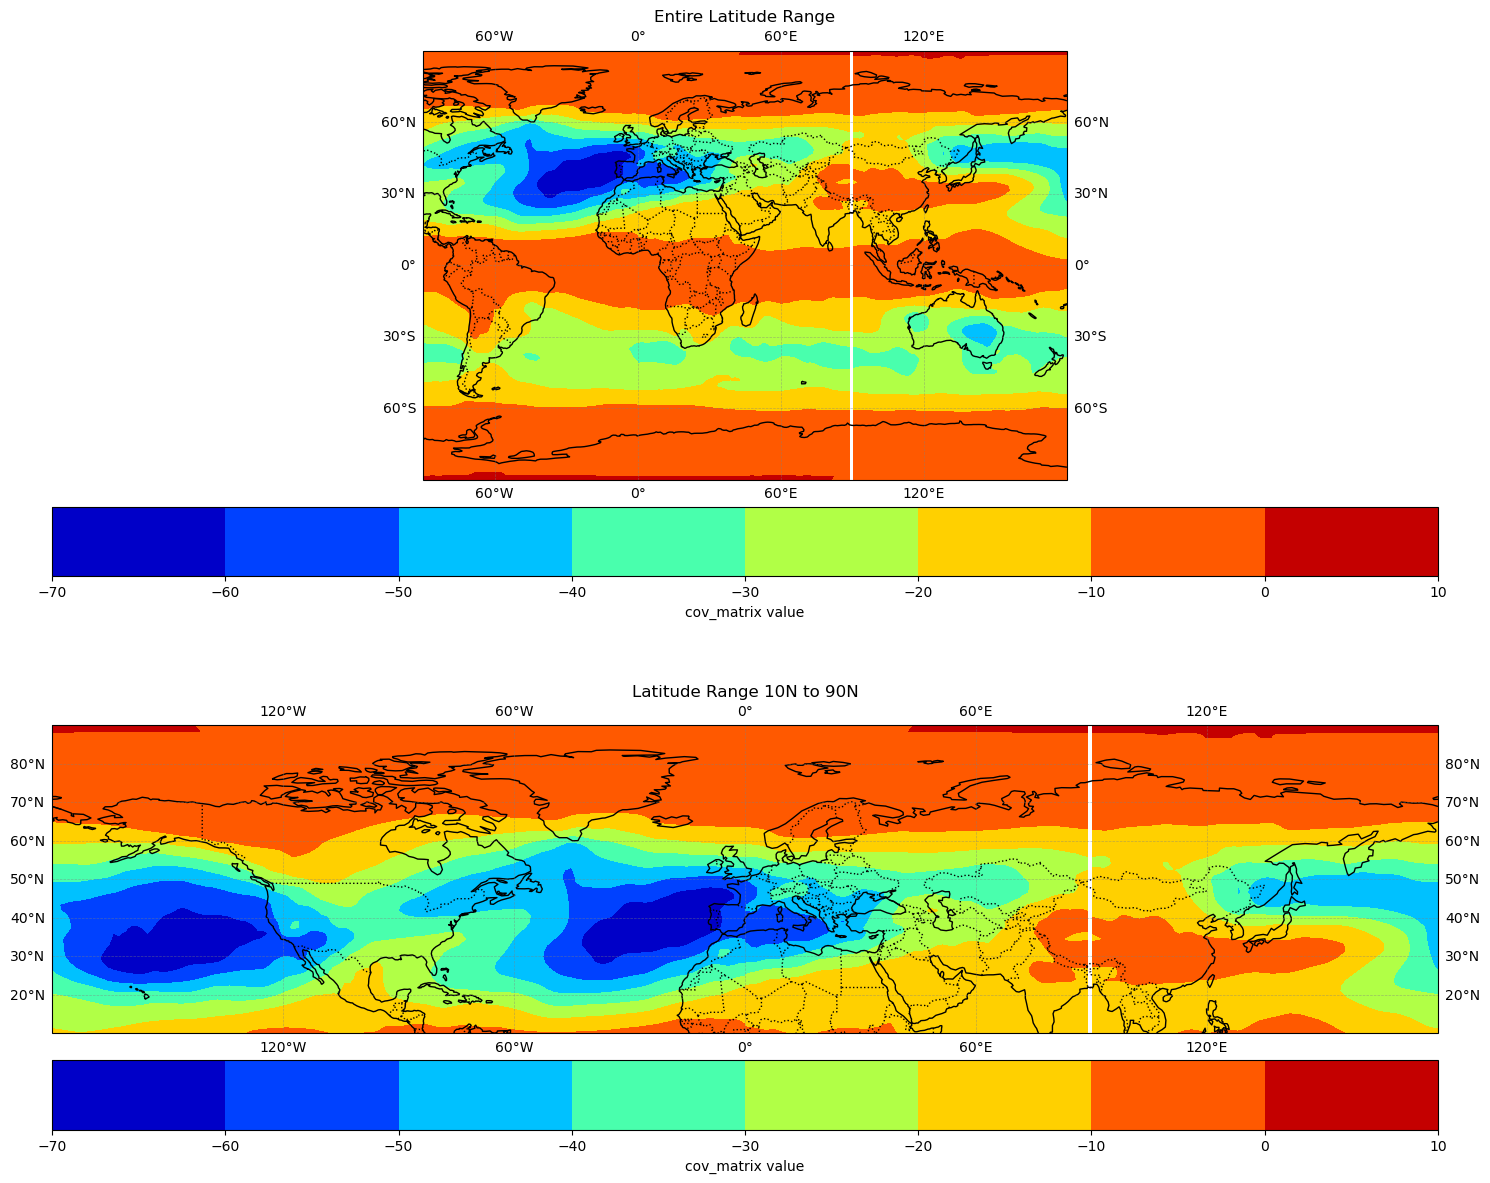

In [6]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Load the saved .npy file
save_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF/cov_matrix_all_year.npy"
cov_matrix = np.load(save_path)

# Rearrange the data to start from 270W in longitude
lon_vals = np.linspace(0, 360, 240)
index_270W = np.argmin(np.abs(lon_vals - 90))
cov_matrix_shifted = np.hstack((cov_matrix[:, index_270W:], cov_matrix[:, :index_270W]))
lon_vals_shifted = np.hstack((lon_vals[index_270W:] - 360, lon_vals[:index_270W]))

# Create a figure with two subplots: one for the entire latitude range and one for 10N to 90N
fig, axs = plt.subplots(nrows=2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
lat_vals = np.linspace(-90, 90, 121)
lons, lats = np.meshgrid(lon_vals_shifted, lat_vals)

for ax in axs:
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([-90, 180, -90, 90])  # Set longitude range from 270W to 90E
    cp = ax.contourf(lons, lats, cov_matrix_shifted, transform=ccrs.PlateCarree(), cmap='jet')
    cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('cov_matrix value')
    
    # Add gridlines to mark latitudes and longitudes
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Set titles for the subplots
axs[0].set_title('Entire Latitude Range')
axs[1].set_extent([-90, 180, 10, 90])
axs[1].set_title('Latitude Range 10N to 90N')

# Display the plots
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import os

# Load the alpha data
save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"
file_path = os.path.join(save_folder, 'slope_data.npy')
alpha_data = np.load(file_path, allow_pickle=True)

# Compute α values' indices for the two coordinates
lat_index_1 = int((90 - 42) / 1.5)
lon_index_1 = int(213 / 1.5)

lat_index_2 = int((90 - 45) / 1.5)
lon_index_2 = int(351 / 1.5)

# Print the indices
print(f"Index for point (213, 42) in the original 2D numpy array: ({lat_index_1}, {lon_index_1})")
print(f"Index for point (351, 45) in the original 2D numpy array: ({lat_index_2}, {lon_index_2})")


Index for point (213, 42) in the original 2D numpy array: (32, 142)
Index for point (351, 45) in the original 2D numpy array: (30, 234)


In [8]:
import numpy as np
import os

save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"
# Path to the saved npy file
file_path = os.path.join(save_folder, 'combined_data_raw.npy')

# Load the data from the npy file
loaded_data = np.load(file_path, allow_pickle=True)

# Print the data format (type) and dimensions
print("Data Type:", type(loaded_data))
print("Shape:", loaded_data.shape)

# Optionally, if you want to see a sample from the data:
print("\nSample Data (from [32, 142] index):", loaded_data[32, 142])


Data Type: <class 'numpy.ndarray'>
Shape: (121, 240)

Sample Data (from [32, 142] index): [(33.36126633346266, 7.932698842892106, '1979_01_01_00'), (38.08271647736797, 6.54591486090407, '1979_01_01_06'), (34.9387986673731, 6.057728876460587, '1979_01_01_12'), (36.16666168636754, 4.900187334975771, '1979_01_01_18'), (48.49099894250791, 4.8110862143855835, '1979_01_02_00'), (42.84842888583701, 6.215488761444912, '1979_01_02_06'), (36.68109218575034, 6.759787306851345, '1979_01_02_12'), (24.093814505634867, 8.868348112560344, '1979_01_02_18'), (19.411501440642613, 10.50522094866516, '1979_01_03_00'), (16.286070363242697, 10.29517076064664, '1979_01_03_06'), (14.852180804943087, 9.689280624640146, '1979_01_03_12'), (18.134616120744045, 7.441430409378235, '1979_01_03_18'), (20.332838512168955, 5.64031929156578, '1979_01_04_00'), (20.059285464058256, 3.814690967536033, '1979_01_04_06'), (20.40173398020097, 3.884714268544003, '1979_01_04_12'), (23.950736589931253, 3.7764531291304158, '1979_01

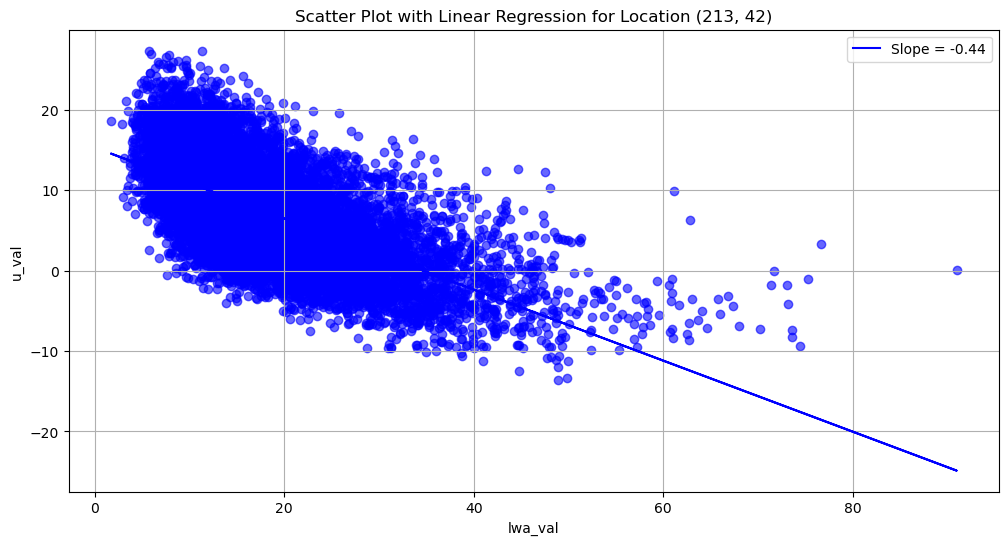

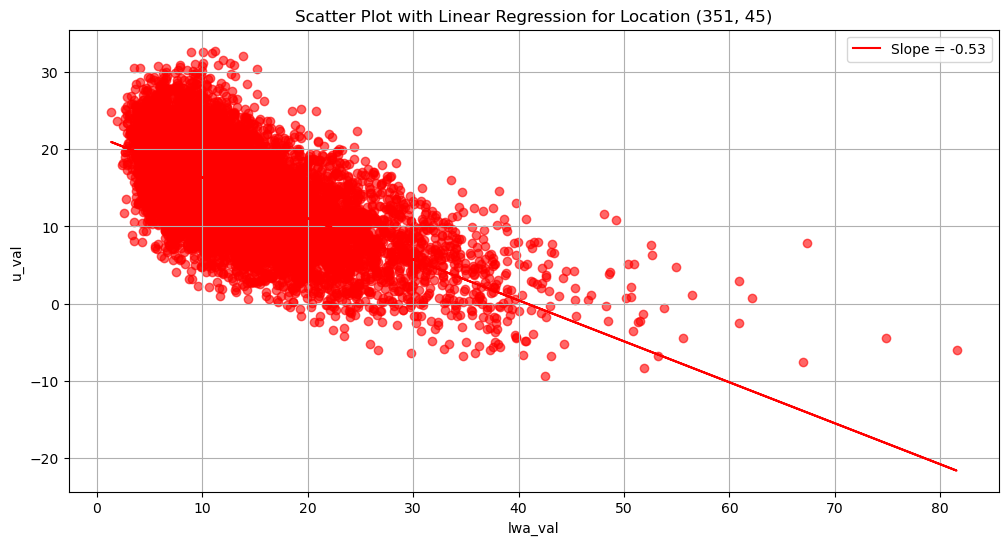

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the data
# save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"
# file_path = os.path.join(save_folder, 'combined_data_raw.npy')
# loaded_data = np.load(file_path, allow_pickle=True)

# Extract data function
def extract_data(point_index):
    lwa_vals = [tup[0] for tup in loaded_data[point_index]]
    u_vals = [tup[1] for tup in loaded_data[point_index]]
    return lwa_vals, u_vals

# 1. Extract the data for the two specified locations
lwa_vals_1, u_vals_1 = extract_data((32, 142))
lwa_vals_2, u_vals_2 = extract_data((30, 234))

# 2. Compute linear regression for the two sets of data
slope_1, intercept_1, _, _, _ = linregress(lwa_vals_1, u_vals_1)
slope_2, intercept_2, _, _, _ = linregress(lwa_vals_2, u_vals_2)

# 3. Plot the scatter plot and linear regression line

# Plot for point (213, 42)
plt.figure(figsize=(12, 6))
plt.scatter(lwa_vals_1, u_vals_1, color='blue', alpha=0.6)
plt.plot(lwa_vals_1, [slope_1*lwa + intercept_1 for lwa in lwa_vals_1], color='blue', label=f'Slope = {slope_1:.2f}')
plt.xlabel('lwa_val')
plt.ylabel('u_val')
plt.title('Scatter Plot with Linear Regression for Location (213, 42)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for point (351, 45)
plt.figure(figsize=(12, 6))
plt.scatter(lwa_vals_2, u_vals_2, color='red', alpha=0.6)
plt.plot(lwa_vals_2, [slope_2*lwa + intercept_2 for lwa in lwa_vals_2], color='red', label=f'Slope = {slope_2:.2f}')
plt.xlabel('lwa_val')
plt.ylabel('u_val')
plt.title('Scatter Plot with Linear Regression for Location (351, 45)')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Load the data
save_folder = "/scratch/negishi/yan481/KenYan_Traffic_Model/alpha_regression_DJF"
file_path = os.path.join(save_folder, 'combined_data_raw.npy')
loaded_data = np.load(file_path, allow_pickle=True)

print("data loading is done!")

# Directory to save scatter plots
scatter_plot_dir = os.path.join(save_folder, 'scatter_plots')
if not os.path.exists(scatter_plot_dir):
    os.makedirs(scatter_plot_dir)

def compute_and_save(index):
    i, j = index
    lwa_vals, u_vals = [tup[0] for tup in loaded_data[i, j]], [tup[1] for tup in loaded_data[i, j]]

    # Check if all lwa_vals are the same
    if len(set(lwa_vals)) == 1:
        print(f"Skipping index ({i},{j}) as all x values are identical.")
        return (i, j, np.nan)  # Return NaN for slope
    
    # Compute slope
    slope, _, _, _, _ = linregress(lwa_vals, u_vals)
    
    # Save scatter plot
    plt.scatter(lwa_vals, u_vals, color='blue', alpha=0.6)
    plt.plot(lwa_vals, [slope*lwa for lwa in lwa_vals], color='red')
    plt.xlabel('lwa_val')
    plt.ylabel('u_val')
    plt.title(f'Scatter Plot for Location ({i}, {j})')
    plt.grid(True)
    plt.savefig(os.path.join(scatter_plot_dir, f'scatter_{i}_{j}.png'))
    plt.close()

    return (i, j, slope)

# Define all points
points = [(i, j) for i in range(loaded_data.shape[0]) for j in range(loaded_data.shape[1])]

slope_data = np.zeros((121, 240))

# Parallelize operations
with ProcessPoolExecutor() as executor:
    for i, j, slope in tqdm(executor.map(compute_and_save, points), total=len(points)):
        slope_data[i, j] = slope

# Save slope data
np.save(os.path.join(save_folder, 'slope_data_djf.npy'), slope_data)


data loading is done!
Skipping index (0,0) as all x values are identical.Skipping index (0,3) as all x values are identical.Skipping index (0,7) as all x values are identical.Skipping index (0,9) as all x values are identical.Skipping index (0,5) as all x values are identical.Skipping index (0,1) as all x values are identical.Skipping index (0,8) as all x values are identical.Skipping index (0,10) as all x values are identical.Skipping index (0,14) as all x values are identical.Skipping index (0,4) as all x values are identical.Skipping index (0,6) as all x values are identical.Skipping index (0,2) as all x values are identical.Skipping index (0,12) as all x values are identical.Skipping index (0,11) as all x values are identical.Skipping index (0,13) as all x values are identical.Skipping index (0,17) as all x values are identical.Skipping index (0,15) as all x values are identical.Skipping index (0,18) as all x values are identical.
Skipping index (0,16) as all x values are identical

Skipping index (0,161) as all x values are identical.Skipping index (0,127) as all x values are identical.Skipping index (0,123) as all x values are identical.Skipping index (0,197) as all x values are identical.Skipping index (0,180) as all x values are identical.
Skipping index (0,192) as all x values are identical.

Skipping index (0,181) as all x values are identical.
Skipping index (0,187) as all x values are identical.
Skipping index (0,101) as all x values are identical.




Skipping index (0,208) as all x values are identical.Skipping index (0,210) as all x values are identical.Skipping index (0,153) as all x values are identical.Skipping index (0,179) as all x values are identical.
Skipping index (0,178) as all x values are identical.

Skipping index (0,167) as all x values are identical.
Skipping index (0,183) as all x values are identical.Skipping index (0,209) as all x values are identical.Skipping index (0,173) as all x values are identical.

Skipping index (0,193) as all 

 59%|█████▉    | 17157/29040 [20:20<10:43, 18.46it/s]  

Skipping index (120,0) as all x values are identical.
Skipping index (120,1) as all x values are identical.
Skipping index (120,4) as all x values are identical.
Skipping index (120,2) as all x values are identical.Skipping index (120,3) as all x values are identical.Skipping index (120,6) as all x values are identical.
Skipping index (120,7) as all x values are identical.


Skipping index (120,5) as all x values are identical.
Skipping index (120,8) as all x values are identical.Skipping index (120,10) as all x values are identical.Skipping index (120,14) as all x values are identical.Skipping index (120,12) as all x values are identical.Skipping index (120,17) as all x values are identical.
Skipping index (120,15) as all x values are identical.Skipping index (120,16) as all x values are identical.
Skipping index (120,18) as all x values are identical.

Skipping index (120,9) as all x values are identical.Skipping index (120,11) as all x values are identical.

Skipping index (120,21) 

Skipping index (120,158) as all x values are identical.Skipping index (120,142) as all x values are identical.Skipping index (120,146) as all x values are identical.
Skipping index (120,167) as all x values are identical.Skipping index (120,161) as all x values are identical.



Skipping index (120,134) as all x values are identical.Skipping index (120,157) as all x values are identical.Skipping index (120,125) as all x values are identical.Skipping index (120,140) as all x values are identical.

Skipping index (120,149) as all x values are identical.

Skipping index (120,163) as all x values are identical.
Skipping index (120,162) as all x values are identical.

Skipping index (120,169) as all x values are identical.Skipping index (120,175) as all x values are identical.Skipping index (120,160) as all x values are identical.Skipping index (120,150) as all x values are identical.



Skipping index (120,173) as all x values are identical.Skipping index (120,165) as all x values are iden

100%|██████████| 29040/29040 [22:48<00:00, 21.23it/s] 
